In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  
from glob import glob 
import random
sns.set_theme(style="whitegrid")

# Proyecto: Clasificación de Neumonía en Rayos-X de Tórax

**Asignatura:** Extensiones de Machine Learning  
**Autor:** Pablo Martínez Galindo  

---

## 1. Introducción Básica al Problema

Este proyecto aborda la tarea de **detección automática de neumonía** a partir de imágenes de rayos-X de tórax. La neumonía es una de las principales causas de mortalidad infantil a nivel mundial.

El diagnóstico mediante radiografías de tórax es una práctica estándar, pero depende en gran medida de la interpretación de un radiólogo experto. Esta interpretación puede ser subjetiva y propensa a errores, especialmente en etapas tempranas de la enfermedad o en entornos con recursos limitados.

El objetivo de este proyecto es explorar el uso de modelos de *deep learning* para crear un **Sistema de Ayuda al Diagnóstico (CAD)**. Un modelo fiable podría actuar como una "segunda opinión" para el personal clínico, ayudando a priorizar casos, reducir la tasa de falsos negativos y agilizar el diagnóstico.

## 2. Obtención de los Datos

Los datos utilizados para este proyecto provienen del siguiente conjunto de datos público:

* **Nombre del Dataset:** "Chest X-Ray Images (Pneumonia)"
* **Fuente Principal (Kaggle):** [https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
* **Origen de los Datos:** Las imágenes fueron recopiladas por el **Guangzhou Women and Children's Medical Center** (Guangzhou, China) y consisten en radiografías de tórax de pacientes pediátricos de entre uno y cinco años.

### Estructura del Dataset

Los datos están organizados en un formato de `ImageFolder`, lo que facilita su carga. El directorio principal contiene tres subcarpetas: `train`, `val` y `test`.

Dentro de cada una de estas subcarpetas, las imágenes (archivos `.jpeg`) están ya clasificadas en dos directorios que definen su etiqueta:
* `NORMAL/` (imágenes de pacientes sanos)
* `PNEUMONIA/` (imágenes de pacientes con diagnóstico de neumonía)

## 3. Tarea para la que se van a Destinar

Los datos se destinarán a una tarea de **clasificación binaria de imágenes**.

> **Objetivo:** Entrenar un modelo que, al recibir una imagen de rayos-X de tórax como entrada, sea capaz de predecir una de las dos posibles etiquetas: `NORMAL` o `PNEUMONIA`.

Para ello, se utilizará un enfoque de **aprendizaje supervisado** y **transferencia de conocimiento (transfer learning)**.

Específicamente, compararemos la eficacia de dos familias de arquitecturas pre-entrenadas una CNN y un Vision Transformer (`EfficientNet-B0` y `ViT-base`) usando dos estrategias de *transfer learning*:

1.  **Extracción de Características:** (Nuestro *baseline*) Congelar los pesos del modelo pre-entrenado y entrenar solo un nuevo clasificador.
2.  **Ajuste Fino (Fine-Tuning):** (Nuestro experimento principal) Descongelar parte o la totalidad de los pesos del modelo pre-entrenado y re-entrenarlos ligeramente con nuestros datos.

La interpretabilidad de los modelos (usando Grad-CAM) también será un factor clave de éxito.

## 4. Informe Básico de Estadística Descriptiva

En esta sección, analizamos las propiedades fundamentales del dataset.

In [ ]:
BASE_PATH = './chest_xray/' 
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'val')
TEST_PATH = os.path.join(BASE_PATH, 'test')

### 4.1. Número de Ejemplos y Distribución de los Datos

Primero, contamos el número exacto de imágenes (ejemplos) en cada conjunto (split) y para cada clase.

In [ ]:
# Usamos glob para contar los archivos .jpeg en cada subdirectorio
counts = {
    'train_normal': len(glob(os.path.join(TRAIN_PATH, 'NORMAL', '*.jpeg'))),
    'train_pneumonia': len(glob(os.path.join(TRAIN_PATH, 'PNEUMONIA', '*.jpeg'))),
    'val_normal': len(glob(os.path.join(VAL_PATH, 'NORMAL', '*.jpeg'))),
    'val_pneumonia': len(glob(os.path.join(VAL_PATH, 'PNEUMONIA', '*.jpeg'))),
    'test_normal': len(glob(os.path.join(TEST_PATH, 'NORMAL', '*.jpeg'))),
    'test_pneumonia': len(glob(os.path.join(TEST_PATH, 'PNEUMONIA', '*.jpeg'))),
}

# Creamos un DataFrame de Pandas para una visualización clara
data = {
    'Set': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
    'Clase': ['Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia'],
    'Nº de Imágenes': [
        counts['train_normal'], counts['train_pneumonia'],
        counts['val_normal'], counts['val_pneumonia'],
        counts['test_normal'], counts['test_pneumonia']
    ]
}
df_counts = pd.DataFrame(data)

# Agrupamos para ver los totales por set
df_summary = df_counts.pivot_table(index='Set', columns='Clase', values='Nº de Imágenes', aggfunc='sum')
df_summary['Total'] = df_summary.sum(axis=1)

print("--- Resumen del Conteo de Imágenes ---")
print(df_summary)

--- Resumen del Conteo de Imágenes ---
Clase       Normal  Pneumonia  Total
Set                                 
Test           234        390    624
Train         1341       3875   5216
Validation       8          8     16


C:\Users\pablo\AppData\Local\Temp\ipykernel_15180\589271819.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Clase', y='Nº de Imágenes', data=train_counts, palette=['#5CB85C', '#D9534F'])


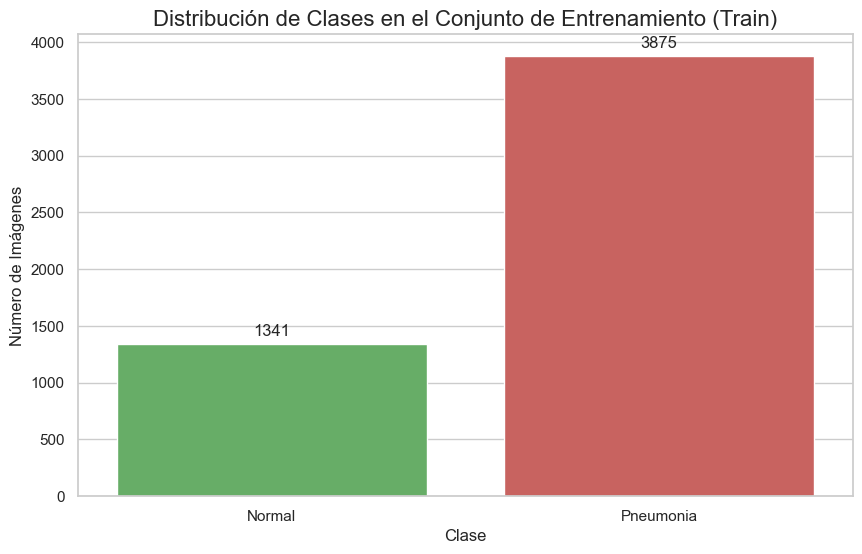

In [ ]:
plt.figure(figsize=(10, 6))
# Filtramos solo por el conjunto de entrenamiento
train_counts = df_counts[df_counts['Set'] == 'Train']

ax = sns.barplot(x='Clase', y='Nº de Imágenes', data=train_counts, palette=['#5CB85C', '#D9534F'])

plt.title('Distribución de Clases en el Conjunto de Entrenamiento (Train)', fontsize=16)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de Imágenes', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.show()

#### Hallazgos Clave de la Distribución:

1.  **Número Total de Ejemplos:** El dataset completo contiene un total de 5,856 imágenes (`train` + `val` + `test`).
2.  **Fuerte Desbalance de Clases:** Como muestra el gráfico, el conjunto de entrenamiento está **muy desbalanceado**. Hay aproximadamente **3 veces más imágenes de `PNEUMONIA` que de `NORMAL`** (3,875 vs. 1,341).
3.  **Implicaciones y Estrategias:** Este desbalance es el desafío más importante del dataset.
    * **Para la Evaluación:** Invalida la métrica "Accuracy" (Precisión global). Nos obliga a centrarnos en **F1-Score**, **Sensibilidad (Recall)** y el análisis de la **Matriz de Confusión**.
    * **Para el Entrenamiento:** Debemos aplicar una estrategia para evitar que el modelo se sesgue hacia la clase mayoritaria. Exploraremos dos enfoques principales en nuestro proyecto:
        * **Estrategia A (Ponderación):** Usar `class_weighting` en la función de pérdida para penalizar más los errores en la clase minoritaria (`NORMAL`).
        * **Estrategia B (Sobremuestreo):** Aplicar **Data Augmentation** (rotaciones, zoom, etc.) de forma selectiva **solo a la clase `NORMAL`** para generar ejemplos sintéticos y crear *batches* de entrenamiento más balanceados.
4.  **Conjunto de Validación (Val):** El conjunto `val` proporcionado es extremadamente pequeño (solo 16 imágenes). Además, como se ha reportado en la comunidad, existe un alto riesgo de *data leakage* (pacientes de `train` que aparecen en `val`/`test`).
    * **Decisión de Proyecto:** Ignoraremos el `val` set proporcionado. En su lugar, **crearemos nuestro propio *split* de validación (ej. 80/20) a partir del conjunto `train`**, usando muestreo estratificado (`stratify=True`) para mantener la proporción de clases original en nuestro nuevo set de validación.

### 4.2. Número de Atributos

Al ser un problema de visión por ordenador, los "atributos" no son columnas en una tabla, sino:

* **Atributo Principal (X):** La imagen en sí. Se representará como un tensor de píxeles de `[Alto, Ancho, Canales]`.
* **Atributo Objetivo (Y):** La etiqueta de la clase, que será codificada numéricamente (ej. `0` para `NORMAL` y `1` para `PNEUMONIA`).

### 4.3. Posibles Valores Nulos

* **Etiquetas:** No existen valores nulos para las etiquetas. Gracias a la estructura de carpetas, cada imagen está intrínsecamente etiquetada por el directorio que la contiene.
* **Imágenes:** Un valor "nulo" en este contexto sería un archivo de imagen corrupto o de 0 bytes que no se puede leer. Se podría ejecutar un script para verificar la integridad de todos los archivos, pero para este informe asumimos que todos los archivos `.jpeg` son legibles.

### 4.4. Características Principales de las Imágenes

#### A. Canales de Color

Las radiografías son en **escala de grises (1 canal)**. Sin embargo, los modelos que usaremos (`EfficientNet`, `ViT`) fueron pre-entrenados en ImageNet, que usa imágenes **RGB (3 canales)**. Por lo tanto, en nuestro *pipeline* de pre-procesamiento, cargaremos las imágenes y **duplicaremos el único canal de grises tres veces** para crear un tensor de 3 canales compatible.

#### B. Dimensiones de las Imágenes (Resolución)

Un paso crucial del EDA es verificar si todas las imágenes tienen el mismo tamaño.

In [ ]:
# Haremos un muestreo de 500 imágenes del set de 'train' para estimar la distribución.

train_normal_files = glob(os.path.join(TRAIN_PATH, 'NORMAL', '*.jpeg'))
train_pneumonia_files = glob(os.path.join(TRAIN_PATH, 'PNEUMONIA', '*.jpeg'))
all_train_files = train_normal_files + train_pneumonia_files

# Asegurarse de que hay archivos para muestrear
if len(all_train_files) > 0:
    random.shuffle(all_train_files)
    
    # Tomamos una muestra de 500 archivos
    sample_size = min(len(all_train_files), 500)
    sample_files = random.sample(all_train_files, sample_size)

    dimensions = []
    for img_path in sample_files:
        try:
            # Leemos la imagen con OpenCV y obtenemos su forma (alto, ancho)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                height, width = img.shape
                dimensions.append((width, height))
            else:
                print(f"Advertencia: No se pudo leer la imagen {img_path}")
        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")

    # Convertimos a DataFrame para análisis
    if dimensions:
        df_dims = pd.DataFrame(dimensions, columns=['Ancho (Width)', 'Alto (Height)'])
        print("\n--- Estadística Descriptiva de Dimensiones (Muestra) ---")
        print(df_dims.describe())
    else:
        print("No se pudieron leer dimensiones de las imágenes.")
else:
    print("No se encontraron archivos de imagen en el directorio de entrenamiento.")


--- Estadística Descriptiva de Dimensiones (Muestra) ---
       Ancho (Width)  Alto (Height)
count     500.000000     500.000000
mean     1319.364000     968.484000
std       339.979139     371.267284
min       446.000000     132.000000
25%      1071.000000     680.000000
50%      1290.000000     872.000000
75%      1546.000000    1183.250000
max      2538.000000    2304.000000


<Figure size 1000x800 with 0 Axes>

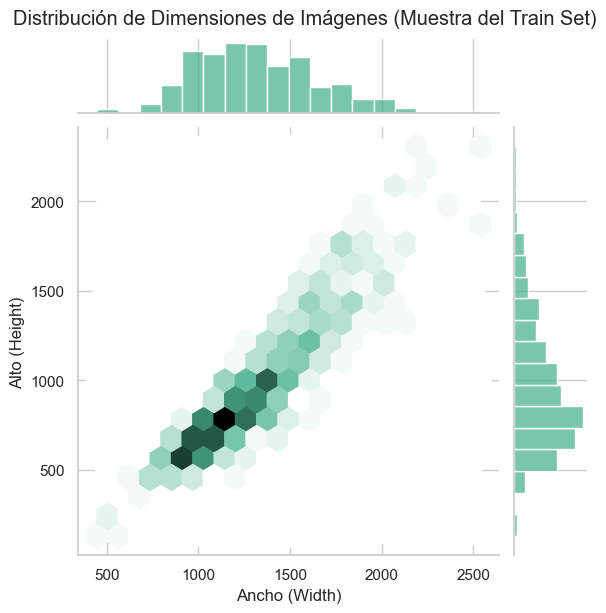

In [ ]:
if 'df_dims' in locals() and not df_dims.empty:
    plt.figure(figsize=(10, 8))
    sns.jointplot(data=df_dims, x='Ancho (Width)', y='Alto (Height)', kind="hex", color="#4CB391")
    plt.suptitle('Distribución de Dimensiones de Imágenes (Muestra del Train Set)', y=1.02)
    plt.show()
else:
    print("No hay datos de dimensiones para graficar.")

#### Hallazgos Clave de las Dimensiones:

Tras ejecutar el análisis sobre una muestra de 500 imágenes, los resultados confirman nuestras sospechas iniciales:

1.  **Tamaños Extremadamente Variables:** El análisis descriptivo y el gráfico de dispersión  demuestran que las imágenes **no tienen un tamaño uniforme**. La resolución varía de forma drástica, con anchos que van desde **446 hasta 2,538 píxeles** y altos desde **132 hasta 2,304 píxeles**.

2.  **Correlación y Agrupación:** El `jointplot` hexagonal muestra una clara **correlación positiva** entre el ancho y el alto; la mayoría de las imágenes son más anchas que altas. A pesar de la alta varianza (desviación estándar de ~340-370 píxeles), la gran mayoría de las imágenes se agrupa en torno a un tamaño medio de **~1319x968 píxeles**.

3.  **Implicaciones (Críticas):** Esta enorme variabilidad dimensional hace que un paso de pre-procesamiento sea **absolutamente necesario**. Todos los *inputs* del modelo deben tener un tamaño fijo (ej., **224x224 píxeles**) para ser procesados en *batches*.
    * **Desafío:** Dado que el tamaño medio de las imágenes (1319x968) es significativamente mayor que nuestro objetivo (224x224), tendremos que aplicar un **redimensionamiento (resize) agresivo**. Esto es un *trade-off* crítico del proyecto: podría causar una pérdida de detalles finos y texturas que son cruciales para el diagnóstico, lo cual deberemos vigilar.